# Predicting the electronic band gap of inorganic materials

by: Alireza Faghaninia (alireza.faghaninia@gmail.com)

data is from: https://pubs.acs.org/doi/10.1021/acs.jpclett.8b00124

* This notebook is an example of matbench that provide material scientists with a set of tools to automate their predictive modeling and get a benchmarking score to evaluate their future models.
* The input is only the chemical formulas! A single column used as the input of matbench workflow.
* Using [matminer](https://github.com/hackingmaterials/matminer) we extract 192 features from the chemical formulas.
* We then use principal component analysis (PCA) with 10 components as it improved the accuracy by reducing the noise in the features.
* A two-stage model: due to the presence of metals (gap=0 eV) in the dataset, a classifier (metal or nonmetal) + a regressor works better than trying to predict the gap with a single regressor.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import pandas as pd
import plotly as ply
import seaborn as sns
from matbench.analysis import Analysis

%matplotlib inline
ply.offline.init_notebook_mode(connected=True)
sns.set()
sns.set_context("poster", font_scale=1.1)

## All inputs:

In [2]:
# inputs
TARGET = ('Input Data', 'gap expt')
CALC_DIR = 'run_data'
SEED = 13
EXCLUDED_FEATURIZERS = ['CohesiveEnergy', 
                        'AtomicPackingEfficiency',
                        'PartialRadialDistributionFunction',
                        'RadialDistributionFunction',
                        'CoulombMatrix',
                        'SineCoulombMatrix',
                        'OrbitalFieldMatrix',
                        'MinimumRelativeDistances',
                        'ElectronicRadialDistributionFunction']
np.random.seed(SEED)
NFOLD = 5 # for cross-validation

## Read the data only containing chemical formula and experimentally measured band gap

In [3]:
from matbench.data.load import load_expt_gap
# df_init = pd.read_csv('../data/sources/gap_expt.csv')
df_init = load_expt_gap()
df_init.head()

,formula,gap expt
0,Hg0.7Cd0.3Te,0.35
1,CuBr,3.08
2,LuP,1.30
3,Cu3SbSe4,0.40
4,ZnO,3.44


## Feature generation: formula -> more than 320 features

In [4]:
from matbench.featurize import Featurize
featzer = Featurize(exclude=EXCLUDED_FEATURIZERS,
                    multiindex=True,
                    drop_featurized_col=True,
                    n_jobs=8)

In [5]:
df_featurized = featzer.featurize_formula(df_init, featurizers="all")

## Preprocessing (drop columns w/ more than 10% nulls + one-hot encoding of str columns)

In [6]:
from matbench.preprocess import PreProcess
prep = PreProcess(target=TARGET, max_colnull=0.1)
df = prep.preprocess(df_featurized)

2018-09-04 18:40:36 INFO     These 20 features were removed as they had more than 10.0% missing values:
{('ElementProperty', 'std_dev bulk_modulus'), ('ElementProperty', 'minimum velocity_of_sound'), ('ElementProperty', 'mean bulk_modulus'), ('ElementProperty', 'maximum coefficient_of_linear_thermal_expansion'), ('ElementProperty', 'range coefficient_of_linear_thermal_expansion'), ('ElementProperty', 'maximum electrical_resistivity'), ('ElementProperty', 'minimum bulk_modulus'), ('ElementProperty', 'mean velocity_of_sound'), ('ElementProperty', 'std_dev electrical_resistivity'), ('ElementProperty', 'maximum velocity_of_sound'), ('ElementProperty', 'range electrical_resistivity'), ('ElementProperty', 'minimum coefficient_of_linear_thermal_expansion'), ('ElementProperty', 'range velocity_of_sound'), ('ElementProperty', 'mean electrical_resistivity'), ('ElementProperty', 'mean coefficient_of_linear_thermal_expansion'), ('ElementProperty', 'std_dev velocity_of_sound'), ('ElementProperty', 

In [7]:
df.head()

,"(Input Data, gap expt)","(ElementProperty, minimum X)","(ElementProperty, maximum X)","(ElementProperty, range X)","(ElementProperty, mean X)","(ElementProperty, std_dev X)","(ElementProperty, minimum row)","(ElementProperty, maximum row)","(ElementProperty, range row)","(ElementProperty, mean row)",...,"('AtomicOrbitals', 'LUMO_element')_Ti","('AtomicOrbitals', 'LUMO_element')_Tl","('AtomicOrbitals', 'LUMO_element')_Tm","('AtomicOrbitals', 'LUMO_element')_U","('AtomicOrbitals', 'LUMO_element')_V","('AtomicOrbitals', 'LUMO_element')_W","('AtomicOrbitals', 'LUMO_element')_Y","('AtomicOrbitals', 'LUMO_element')_Yb","('AtomicOrbitals', 'LUMO_element')_Zn","('AtomicOrbitals', 'LUMO_element')_Zr"
"(Input Data, formula)",,,,,,,,,,,,,,,,,,,,,
Hg0.7Cd0.3Te,0.35,1.69,2.10,0.41,2.00350,0.179083,5.0,6.0,1.0,5.350,...,0,0,0,0,0,0,0,0,0,0
CuBr,3.08,1.90,2.96,1.06,2.43000,0.749533,4.0,4.0,0.0,4.000,...,0,0,0,0,0,0,0,0,0,0
LuP,1.30,1.27,2.19,0.92,1.73000,0.650538,3.0,8.0,5.0,5.500,...,0,0,0,0,0,0,0,0,0,0
Cu3SbSe4,0.40,1.90,2.55,0.65,2.24375,0.401887,4.0,5.0,1.0,4.125,...,0,0,0,0,0,0,0,0,0,0
ZnO,3.44,1.65,3.44,1.79,2.54500,1.265721,2.0,4.0,2.0,3.000,...,0,0,0,0,0,0,0,0,1,0


## Data visualization (unbalanced, many metals (target=0))

Let's start by the distribution of the target:

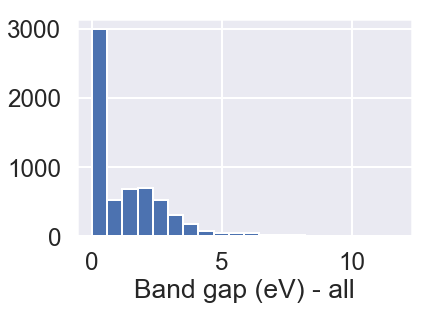

In [8]:
ax = df[TARGET].hist(bins=20)
ax.set_xlabel('Band gap (eV) - all');

In [9]:
print('{:.2f}% of the compounds are metal (expt gap == 0 eV)'.format(sum(df[TARGET]==0)/len(df)*100))

39.30% of the compounds are metal (expt gap == 0 eV)


We note that it is very unbalanced with most of the target variable being close to 0 (metals). Metals have very different properties and chemistry than nonmetals (gap>0). We return to this point in the following sections.

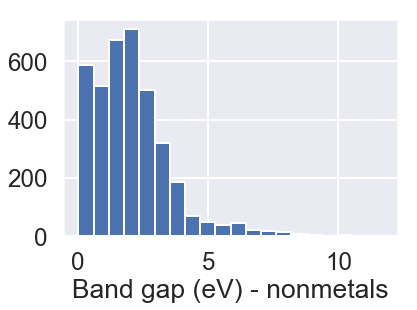

In [10]:
ax = df[TARGET][df[TARGET]>0.0].hist(bins=20)
ax.set_xlabel('Band gap (eV) - nonmetals');

Much better! Although, the high band-gap materials/insulators are still underrepresented.

## Further pre-processing of the data: standardization + PCA

We generated more than 300 features some of which are highly cross-correlated and some may be just noise for this particular problem. I already tried training a random forest with a full feature set and the performance is much poorer than (RMSE difference of ~ 0.25 eV!). So, we proceed with standardization+PCA:

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop(TARGET, axis=1))

In [12]:
from sklearn.decomposition import PCA
N_COMPONENTS = 10
pca = PCA(n_components=N_COMPONENTS)

In [13]:
df_pca = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(df_pca, columns=['PCA{}'.format(i+1) for i in range(N_COMPONENTS)], index=df.index)

In [14]:
df_pca.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10
"(Input Data, formula)",,,,,,,,,,
Hg0.7Cd0.3Te,5.345642,-2.340511,2.496895,-0.366101,-1.870263,0.135581,-1.454732,-0.074508,1.174569,1.994567
CuBr,2.305238,-1.036593,-5.239440,0.007534,-5.687478,1.904117,4.181306,1.195812,-1.568272,-0.648261
LuP,0.536487,2.833398,3.931115,-2.656278,1.121773,-2.569535,1.212774,0.264647,-2.871355,2.366970
Cu3SbSe4,2.787081,-0.658015,-4.391065,-0.802652,-5.120643,2.406673,2.875994,-1.591907,-1.207159,-0.433770
ZnO,-2.368389,-3.718579,-1.827168,-1.226492,0.221911,0.883704,1.703703,4.057939,2.562604,0.438240


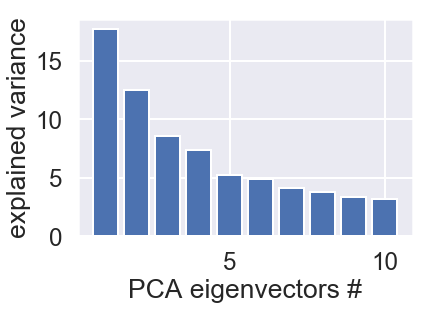

In [15]:
plt.bar(height=pca.explained_variance_, x=range(1, N_COMPONENTS+1));
plt.ylabel('explained variance');
plt.xlabel('PCA eigenvectors #');

In [16]:
# from matminer.figrecipes.plot import PlotlyFig

# pf = PlotlyFig(df_pca, mode='notebook', margins=0, x_title='PCA1', y_title='PCA2')
# pf.xy(('PCA1', 'PCA2'), labels=df.index, colors=df[TARGET])

Looking at this plot we learn that the compounds don't particularly cluster based on the first 2 PCA directions. So, we need more than just 2 PCA features to model this data. Also, not even in terms of metal/nonmetal which may be one more reason to have separate classifier for metal/nonmetal.

# Training models

In [17]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
rf_params_dict = {
        'n_estimators': [100, 200, 400],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'bootstrap': [True, False]
    }

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_pca, df[TARGET], test_size=0.2, random_state=SEED)

## 1) Single model on the mixed data (metals + nonmetals: higher RMSE)

In [19]:
model_reg1 = RandomizedSearchCV(estimator=RandomForestRegressor(), 
                           random_state=SEED,
                           param_distributions=rf_params_dict,
                           n_iter=15,
                           scoring='neg_mean_squared_error',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)
# with open(os.path.join(CALC_DIR, 'rf_mixed_optimized.pickle'), 'rb') as fm:
#     model_reg1 = pickle.load(fm)

In [20]:
model_reg1.fit(X_train, y_train)
with open(os.path.join(CALC_DIR, 'rf_mixed_optimized.pickle'), 'wb') as fm:
    pickle.dump(model_reg1, fm)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   44.3s finished


In [21]:
model_reg1.score(X_test, y_test)

-0.6930154361423736

In [22]:
y_pred = model_reg1.predict(X_test)
r2_score(y_test, y_pred)

0.6950766268671557

In [23]:
model_reg1.best_params_

{'n_estimators': 200,
 'min_samples_split': 17,
 'min_samples_leaf': 1,
 'max_features': 0.5,
 'bootstrap': False}

In [25]:
from sklearn.model_selection import KFold, cross_val_score

cv = KFold(n_splits=NFOLD, shuffle=False, random_state=SEED)
model_cv = RandomForestRegressor(**model_reg1.best_params_, n_jobs=-1)

rmse_scores = [np.sqrt(abs(score)) for score in cross_val_score(model_cv, df_pca, df[TARGET], scoring='neg_mean_squared_error', cv=cv)]
print('{}-fold cross-validation scores for the basic model (metals+nonmentals)'.format(NFOLD))
print('RMSE: {0:.4f} +- {1:.4f}'.format(np.mean(rmse_scores), np.std(rmse_scores)))

5-fold cross-validation scores for the basic model (metals+nonmentals)
RMSE: 0.9001 +- 0.0649


In [26]:
from matminer.figrecipes.plot import PlotlyFig
pf = PlotlyFig(mode='notebook', margins=0, x_title='Actual gap (eV)', y_title='Predicted gap (eV)')
pf.xy([(y_test, y_pred)], labels=X_test.index, colors=X_test['PCA1'])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


## 2) Two models: 1 regressor on nonmetals + 1 classifier for metal/nonmetals

### Regressor for nonmetals (gap > 0)

In [83]:
df_pca_seco = df_pca[df[TARGET]>0]

In [84]:
X_train, X_test, y_train, y_test = train_test_split(df_pca_seco, df[df[TARGET]>0][TARGET], test_size=0.2, random_state=SEED)

In [92]:
model_reg2 = RandomizedSearchCV(estimator=RandomForestRegressor(), 
                           random_state=SEED,
                           param_distributions=rf_params_dict,
                           n_iter=15,
                           scoring='neg_mean_squared_error',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)
# with open(os.path.join(CALC_DIR, 'rf_optimized.pickle'), 'rb') as fm:
#     model_reg2 = pickle.load(fm)

In [93]:
model_reg2.fit(X_train, y_train)
with open(os.path.join(CALC_DIR, 'rf_optimized.pickle'), 'wb') as fm:
    pickle.dump(model_reg2, fm)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   30.1s finished


In [94]:
model_reg2.score(X_test, y_test)

-0.347173430557449

In [95]:
y_pred = model_reg2.predict(X_test)
r2_score(y_test, y_pred)

0.8580584121922457

In [96]:
from sklearn.model_selection import KFold, cross_val_score

cv = KFold(n_splits=NFOLD, shuffle=False, random_state=SEED)
model_cv2 = RandomForestRegressor(**model_reg2.best_params_, n_jobs=-1)

rmse_scores = [np.sqrt(abs(score)) for score in cross_val_score(model_cv2, df_pca_seco, df[df[TARGET]>0][TARGET], scoring='neg_mean_squared_error', cv=cv)]
print('{}-fold cross-validation scores for the model only nonmentals'.format(NFOLD))
print('RMSE: {0:.4f} +- {1:.4f}'.format(np.mean(rmse_scores), np.std(rmse_scores)))

5-fold cross-validation scores for the model only nonmentals
RMSE: 0.5843 +- 0.0487


In [97]:
from matminer.figrecipes.plot import PlotlyFig
pf = PlotlyFig(mode='notebook', margins=0, x_title='Actual gap (eV)', y_title='Predicted gap (eV)')
pf.xy([(y_test, y_pred)], labels=X_test.index, colors=X_test['PCA1'])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


###  Metal vs. Non-metal Classifier

In [115]:
cassification_ismetal = df[TARGET].apply(lambda x: int(x==0))
sum(cassification_ismetal)/len(cassification_ismetal)

0.392954801351134

In [116]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_pca, cassification_ismetal, test_size=0.2, random_state=SEED)

In [117]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=NFOLD, shuffle=False, random_state=SEED)

In [118]:
from sklearn.ensemble import RandomForestClassifier # actually SVC here scores similarly

model_cls = RandomizedSearchCV(estimator=RandomForestClassifier(
    class_weight={0: 1., 1:1./(sum(cassification_ismetal)/len(df))}), 
                           random_state=SEED,
                           param_distributions=rf_params_dict,
                           n_iter=80,
                           scoring='roc_auc',
                           cv=cv,
                           verbose=1,
                           n_jobs=-1)
# with open(os.path.join(CALC_DIR, 'classifier_optimized.pickle'), 'rb') as fm:
#     model_cls = pickle.load(fm)

In [119]:
model_cls.fit(X_train, y_train)
with open(os.path.join(CALC_DIR, 'classifier_optimized.pickle'), 'wb') as fm:
    pickle.dump(model_cls, fm)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  4.8min finished


In [120]:
model_cls.score(X_test, y_test)

0.9692904812958669

In [121]:
from sklearn.model_selection import cross_val_score

model_cv3 = RandomForestClassifier(**model_cls.best_params_, n_jobs=-1)

rmse_scores = [np.sqrt(abs(score)) for score in cross_val_score(model_cv3, df_pca, cassification_ismetal, scoring='roc_auc', cv=cv)]
print('{}-fold cross-validation scores for the classification (metal/nonmetal) model'.format(NFOLD))
print('RMSE: {0:.4f} +- {1:.4f}'.format(np.mean(rmse_scores), np.std(rmse_scores)))

5-fold cross-validation scores for the classification (metal/nonmetal) model
RMSE: 0.9852 +- 0.0034


In [175]:
from sklearn.metrics import confusion_matrix
from collections import Counter
# y_pred = model_cls.predict(X_test)
y_pred = list(map(int, model_cls.predict_proba(X_test)[:, 1] > 0.55)) # if .8, we only throw away 3.6% of the data as metal
cm = confusion_matrix(y_test, y_pred)/np.array([Counter(y_pred)[0], Counter(y_pred)[1]])

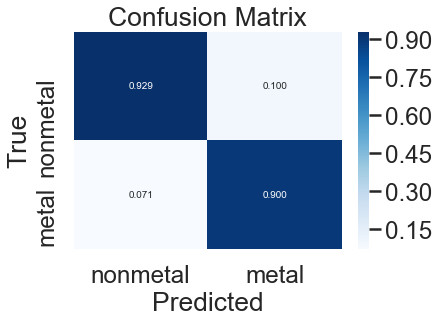

In [176]:
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.3f');
ax.set_xlabel('Predicted');
ax.set_ylabel('True'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['nonmetal', 'metal']); 
ax.yaxis.set_ticklabels(['nonmetal', 'metal']);

In [177]:
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_proba = model_cls.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba, pos_label=1, drop_intermediate=True)

Text(0,0.5,'True positive rate')

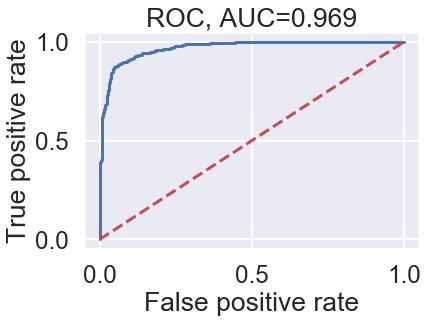

In [178]:
plt.plot(fpr, tpr);
plt.plot([0., 1.], [0., 1.], 'r--')
plt.title('ROC, AUC={0:.3f}'.format(roc_auc_score(y_test, y_pred_proba)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

(0, 0.9)

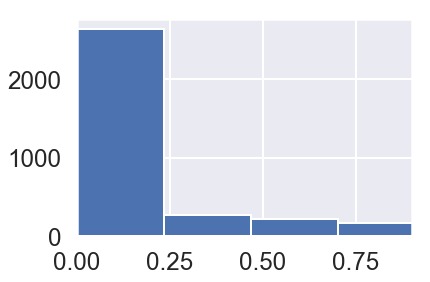

In [229]:
df[TARGET].hist(bins=50)
plt.xlim([0, 0.9])

In [200]:
1- sum(test_is_metal)/len(test_is_metal)

0.4736842105263158

## Metal vs. low-gap semiconductor vs. semiconductor vs. insulator classifier

In [241]:
thresholds=(-1000, 0.0, 0.5, 1.5, 1000.0)
df['multi_class'] = df[TARGET]
for iclass in range(len(thresholds)-1):
    df['multi_class'][(df[TARGET]>thresholds[iclass]) & (df[TARGET]<=thresholds[iclass+1])] = iclass

df['multi_class'] = df['multi_class'].astype(int)

In [243]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_pca, df['multi_class'], test_size=0.2, random_state=SEED)

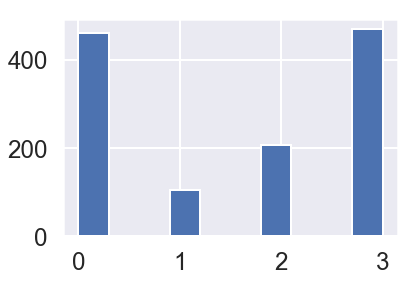

In [250]:
y_test.hist();

In [297]:
from sklearn.ensemble import RandomForestClassifier # actually SVC here scores similarly

model_multicls = RandomizedSearchCV(estimator=RandomForestClassifier(
    class_weight={i:len(df)/sum(df['multi_class']==i) for i in range(len(df['multi_class'].unique()))}), 
                           random_state=SEED,
                           param_distributions=rf_params_dict,
                           n_iter=100,
                           scoring='f1_weighted',
                           cv=cv,
                           verbose=1,
                           n_jobs=2)
# with open(os.path.join(CALC_DIR, 'multiclass_classifier_optimized.pickle'), 'rb') as fm:
#     model_cls = pickle.load(fm)

In [298]:
model_multicls.fit(X_train, y_train.values)
with open(os.path.join(CALC_DIR, 'multiclass_classifier_optimized.pickle'), 'wb') as fm:
    pickle.dump(model_cls, fm)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  6.4min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed: 13.6min
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed: 15.5min finished


In [299]:
from sklearn.metrics import confusion_matrix
from collections import Counter
y_pred = model_multicls.predict(X_test)
cm = confusion_matrix(y_test, y_pred)/np.array([Counter(y_pred)[i] for i in range(len(thresholds)-1)])

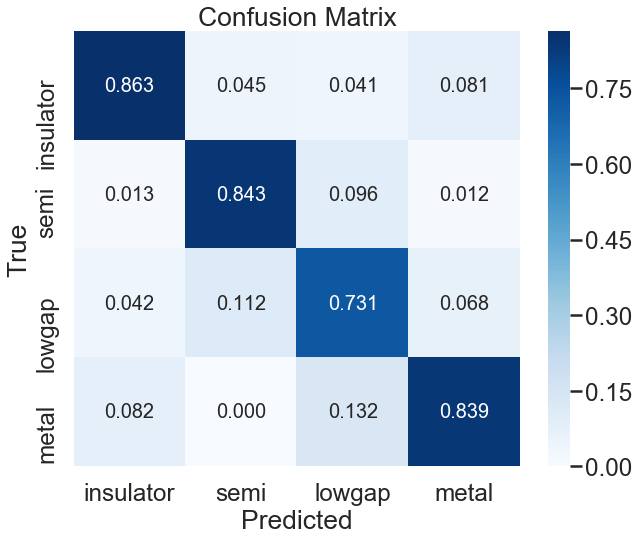

In [300]:
plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.3f', annot_kws={"size": 20});
ax.set_xlabel('Predicted');
ax.set_ylabel('True'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['insulator', 'semi', 'lowgap', 'metal']); 
ax.yaxis.set_ticklabels(['insulator', 'semi', 'lowgap', 'metal']);

As we see the score of multi-class classification is lower than metal/nonmetal only